# JUMPER STEP BY STEP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys 
import os
import pickle
import random 
sys.path.insert(0,"../lib/")
from forecast import Predictions, Simulation, load_ts
#import importlib
#importlib.reload(jumper)

## What parameters we can change?

### Load and Prepare simulations
- path  : path of the simulation - string
- ye    : yearly average of the simulation - bool
- start : start for the training data int
- end   : end for the training data - int
- comp  : explained variance ratio - float or int

### Predictions:
- steps : Number of steps to forecast

In [2]:
path  = "/scratchu/mtissot/SIMUp6Y"
ye    = True
start = 25
end   = 125
comp  = None #default = 0.9
steps = 30

# **LOAD & PREPARE**

#### Calling the Simulation class:
- Load sea surface height, salinity and temperature
- get other attributes (see init code)

#### Calling self.prepare function
- Cut start and end
- Compute mean, std, max etc...
- Standardize default = true

In [3]:
simu_zos    = Simulation(path=path,start=start,end=end,ye=ye,term="zos")    
print("zos loaded")
simu_so     = Simulation(path=path,start=start,end=end,ye=ye,term="so")   
print("so loaded")
simu_thetao = Simulation(path=path,start=start,end=end,ye=ye,term="thetao")   
print("thetao loaded")


simu_zos.prepare() 
print("\nzos prepared")
simu_so.prepare() 
print("so prepared")
simu_thetao.prepare() 
print("thetao prepared")


#LoadSimu : essayer avec des chunks plus gros et plus de jobs pour 3D 
#Prepare   : Cut spin Up - Remove Closed seas - Standardize - (old : Replace bathy nan values by the mean) - to float32

zos loaded
so loaded
thetao loaded

zos prepared
so prepared
thetao prepared


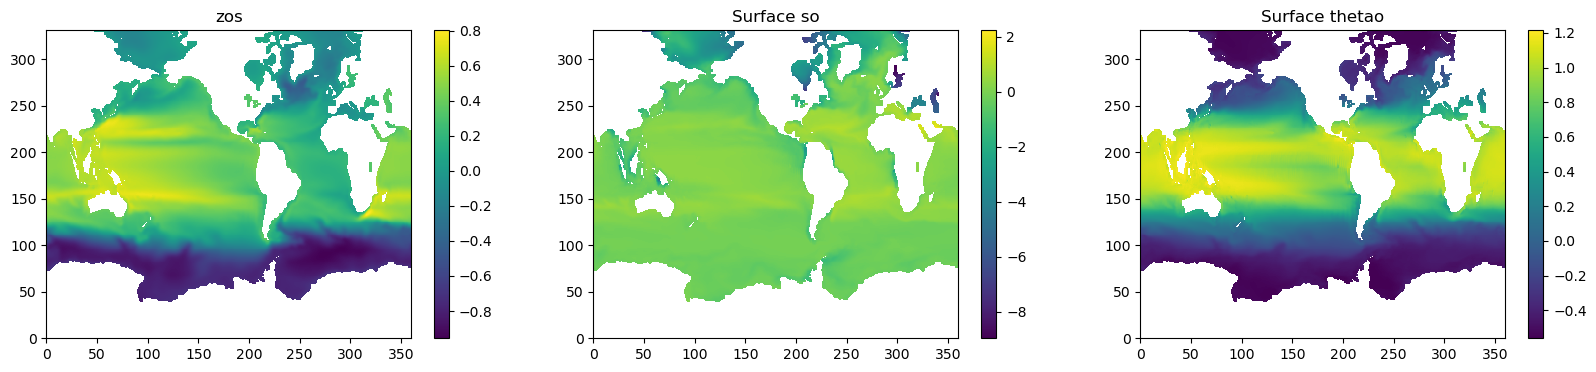

In [4]:
simus = [simu_zos,simu_so,simu_thetao]
names = ["zos","so","thetao"]

fig, axes = plt.subplots(1,len(simus), figsize=(20,4))

for i, simu in enumerate(simus):
    if simu.z_size is not None : 
        im = axes[i].pcolor(simu.simulation[0,0])
        axes[i].set_title(f"Surface {names[i]}")
    else:
        im = axes[i].pcolor(simu.simulation[0])
        axes[i].set_title(f"{names[i]}")
    plt.colorbar(im, ax=axes[i])

if False:
    fig, axes = plt.subplots(1,len(simus), figsize=(20,4))

    for i, simu in enumerate(simus):
        if simu.z_size is not None : 
            plt.plot(np.mean(simu.desc["ssca"],axis=(1,2,3)))
            axes[i].set_title(f"Average ssca - {names[i]}")
        else:
            plt.plot(np.mean(simu.desc["ssca"],axis=(1,2)))
            axes[i].set_title(f"Average ssca - {names[i]}")
    plt.colorbar(im, ax=axes[i])

# **TO TIME SERIES**

#### Calling the applyPCA function:
- Compute the pca on simulation and obtain self.components and self.pca attributes

#### Calling the rmseOfPCA function:
- Return the reconstructed simulation, rmse values and maps

#### last steps => save prepared simu and infos

In [5]:
simu_zos.applyPCA()
print("PCA applied on zos")
simu_so.applyPCA()
print("PCA applied on so")
simu_thetao.applyPCA()
print("PCA applied on thetao")

PCA applied on zos
PCA applied on so
PCA applied on thetao


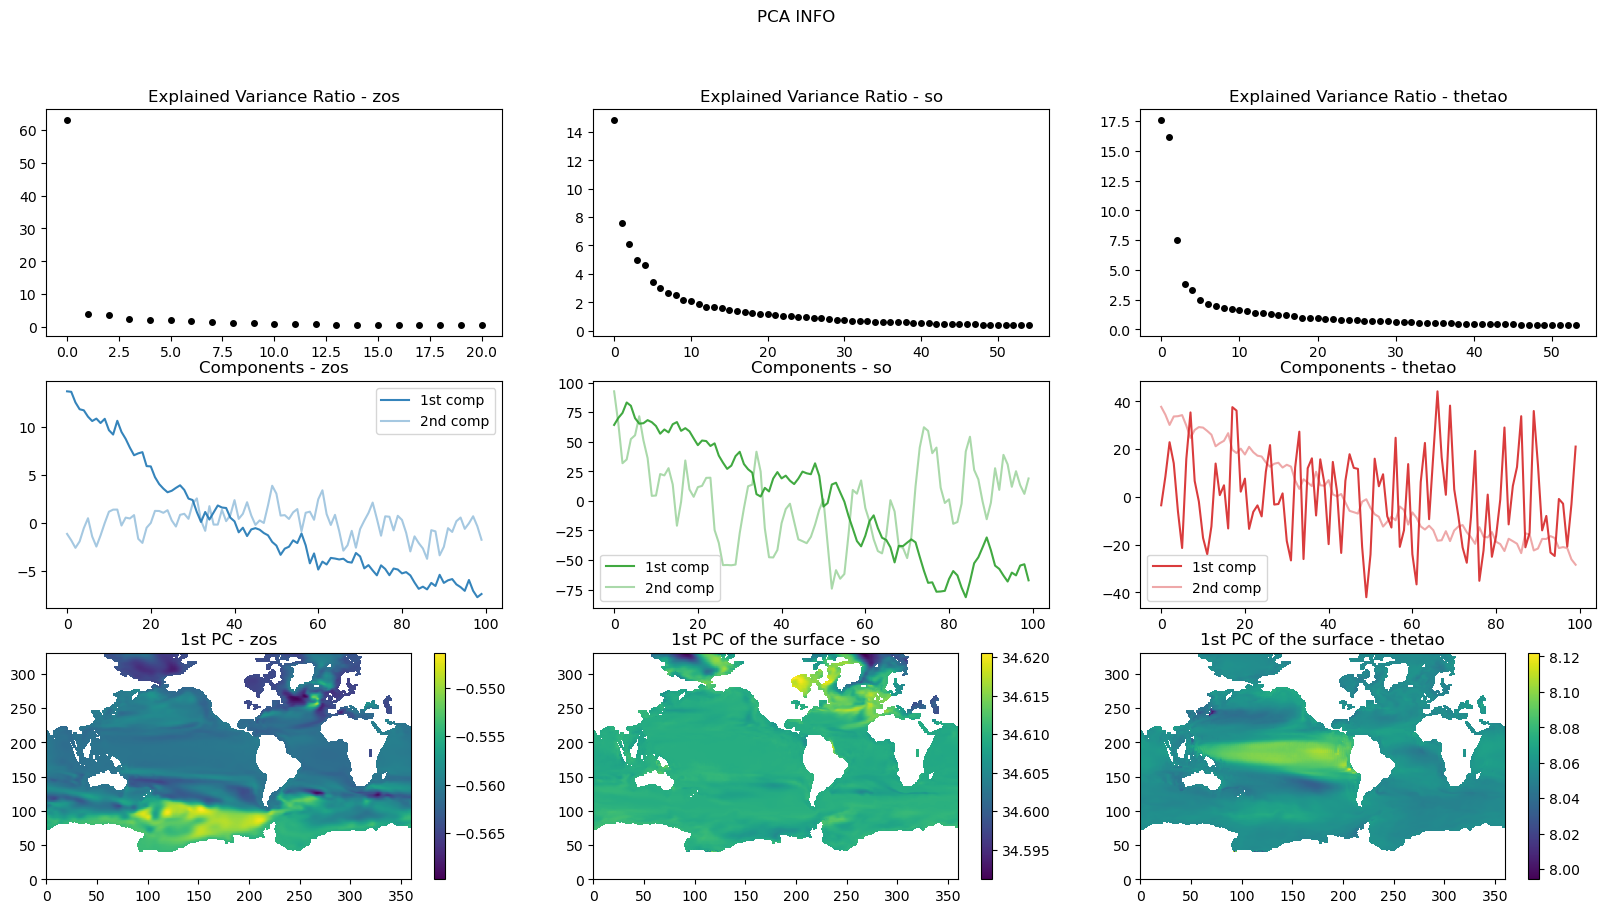

In [6]:
simus = [simu_zos,simu_so,simu_thetao]
names = ["zos","so","thetao"]
colors = ["tab:blue","tab:green","tab:red"]
fig, axes = plt.subplots(3, 3, figsize=(20, 10))

for i, simu in enumerate(simus):
    axes[0, i].plot(simu.pca.explained_variance_ratio_*100,"ko", markersize =4)
    axes[0, i].set_title(f"Explained Variance Ratio - {names[i]}")

    axes[1, i].plot(simu.components[:, 0], color=colors[i], alpha=0.9, label="1st comp")
    axes[1, i].plot(simu.components[:, 1], color=colors[i], alpha=0.4, label="2nd comp")
    axes[1, i].set_title(f"Components - {names[i]}")
    axes[1, i].legend()
    
    if simu.z_size is not None : 
        im = axes[2, i].pcolor(simu.getPC(0)[0])
        plt.colorbar(im, ax=axes[2, i])#,label=units[i])
        axes[2, i].set_title(f"1st PC of the surface - {names[i]}")
    else:
        im = axes[2, i].pcolor(simu.getPC(0))
        plt.colorbar(im, ax=axes[2, i])#,label=units[i])
        axes[2, i].set_title(f"1st PC - {names[i]}")
        
fig.suptitle("PCA INFO")
plt.show()

In [7]:
n = len(simu_zos.pca.explained_variance_ratio_)
rec_zos,    rmseV_zos,    rmseM_zos    = simu_zos.rmseOfPCA(n)
print("RMSE compilated for zos")
n = len(simu_so.pca.explained_variance_ratio_)
rec_so,     rmseV_so,     rmseM_so     = simu_so.rmseOfPCA(n)
print("RMSE compilated for so")
n = len(simu_thetao.pca.explained_variance_ratio_)
rec_thetao, rmseV_thetao, rmseM_thetao = simu_thetao.rmseOfPCA(n)
print("RMSE compilated for thetao")

RMSE compilated for zos
RMSE compilated for so
RMSE compilated for thetao


In [8]:
import xarray as xr
array = xr.open_dataset(simu_so.files[-1], decode_times=False,chunks={"time": 200, "x":120})

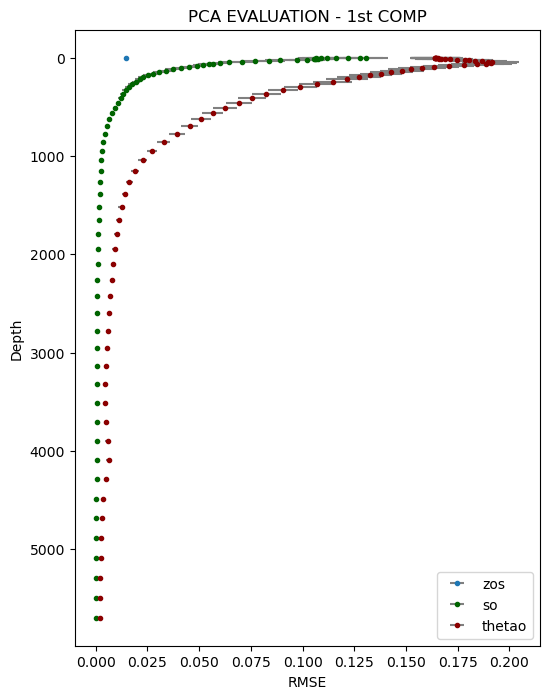

In [9]:
rmseV_zos
values = [rmseV_zos, rmseV_so.T, rmseV_thetao.T]
maps   = [rmseM_zos, rmseM_so, rmseM_thetao]
names  = ["zos", "so", "thetao"]
colors = ["tab:blue", "darkgreen", "darkred"]

fig = plt.figure(figsize=(6,8))
for i in range(3):
    if i == 0:
        plt.errorbar(np.mean(values[i]), array.deptht[0], xerr=np.std(values[i]), fmt='.', label=names[i], color=colors[i], ecolor="grey")
    else:
        plt.errorbar(np.mean(values[i], axis=1), array.deptht, xerr=np.std(values[i], axis=1), fmt='.', label=names[i], color=colors[i], ecolor="grey")

plt.title("PCA EVALUATION - 1st COMP")
plt.ylabel("Depth")
plt.xlabel("RMSE")
plt.legend()

plt.gca().invert_yaxis()
plt.show()


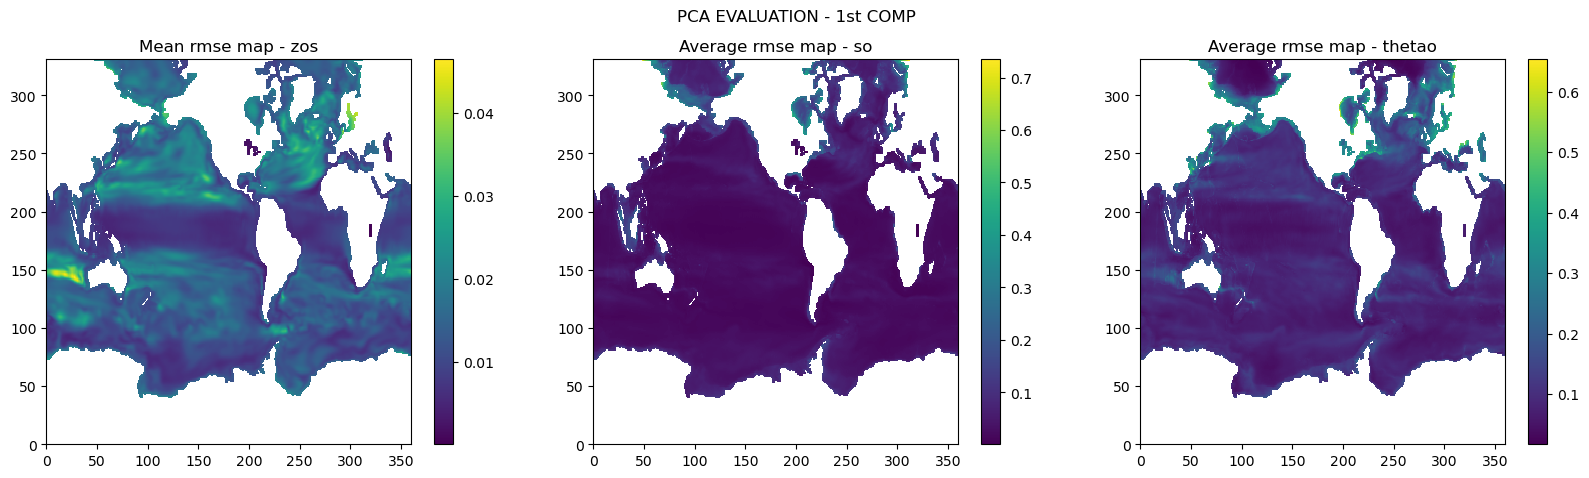

In [10]:
values = [rmseV_zos,rmseV_so,rmseV_thetao]
maps   = [rmseM_zos,rmseM_so,rmseM_thetao]
names  = ["zos","so","thetao"]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i in range(3):
    if len(np.shape(maps[i]))==2: 
        im = axes[i].pcolor(maps[i])
        plt.colorbar(im, ax=axes[i])
        axes[i].set_title(f"Mean rmse map - {names[i]}")
    else:
        im = axes[i].pcolor(np.nanmean(maps[i],axis=0))
        plt.colorbar(im, ax=axes[i])
        axes[i].set_title(f"Average rmse map - {names[i]}")
            
fig.suptitle("PCA EVALUATION - 1st COMP")
plt.show()

In [11]:
zos_dico = simu_zos.makeDico()
print("zos to dictionnary")
so_dico = simu_so.makeDico()
print("so to dictionnary")
thetao_dico = simu_thetao.makeDico()
print("thetao to dictionnary")

zos to dictionnary
so to dictionnary
thetao to dictionnary


In [12]:
f = "/data/mtissot/spinup_data/simus_prepared/"
if not os.path.exists(f):
    os.makedirs(f)

with open(f + 'pca_so', 'wb') as file:
    pickle.dump(simu_so.pca, file)
with open(f + 'pca_thetao', 'wb') as file:
    pickle.dump(simu_thetao.pca, file)
with open(f + 'pca_zos', 'wb') as file:
    pickle.dump(simu_zos.pca, file)

np.savez(f + "so", **so_dico)
np.savez(f + "thetao", **thetao_dico)
np.savez(f + "zos", **zos_dico)


# **FORECAST**

#### Calling the load_ts function:
- get all components in a panda dataframe

#### Calling Predictions class:
- Get components, gp etc...

#### Calling Forecats function: 
- Compute forecast_ts for each time series

#### Calling reconstruct function: 
- reconstruct predictions and train predictions

In [16]:
f = "/data/mtissot/spinup_data/simus_prepared/"

df_zos,infos_zos       = load_ts(f,"zos")
df_so,infos_so         = load_ts(f,"so")
df_thetao,infos_thetao = load_ts(f,"thetao")

random.seed(20)

ts_zos    = Predictions("zos",df_zos,infos_zos)  
ts_so     = Predictions("so",df_so,infos_so)  
ts_thetao = Predictions("thetao",df_thetao,infos_thetao)  

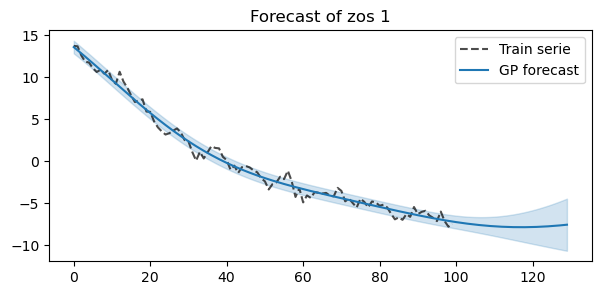

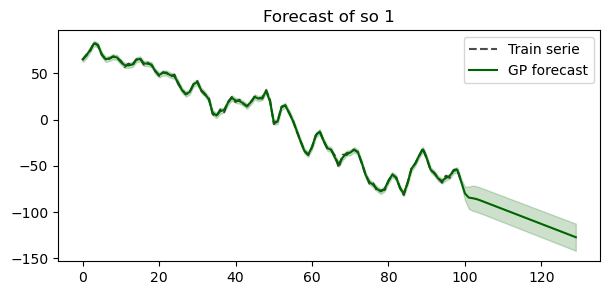

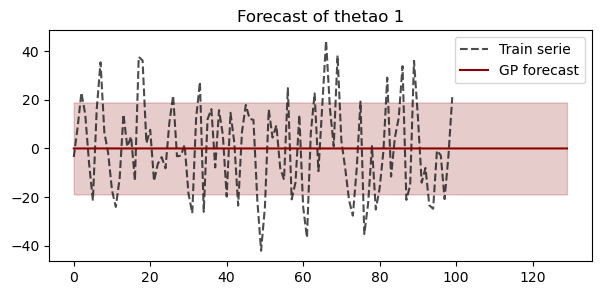

In [30]:
import random
random.seed(100)
comp,train_len,steps=1,len(ts_zos),30#,20#len(ts_zos),30

hat_zos,    std_zos,    metrics_zos    = ts_zos.forecast_ts(comp,train_len,steps)
hat_so,     std_so,     metrics_so     = ts_so.forecast_ts(comp,train_len,steps)
hat_thetao, std_thetao, metrics_thetao = ts_thetao.forecast_ts(comp,train_len,steps)

ts_zos.show(comp,hat_zos,std_zos,train_len)
ts_so.show(comp,hat_so,std_so,train_len,color="darkgreen")
ts_thetao.show(comp,hat_thetao,std_thetao,train_len,color="darkred")

In [31]:
hat_zos,    hat_std_zos,    metrics = ts_zos.Forecast(train_len,steps)
hat_so,     hat_std_so,     metrics = ts_so.Forecast(train_len,steps)
hat_thetao, hat_std_thetao, metrics = ts_thetao.Forecast(train_len,steps)

In [24]:
#CHANGER PRENDRE SERIE TEMP TRUTH + PRED
n = np.shape(ts_zos.info["ts"])[1]
predictions_zos     = ts_zos.reconstruct(hat_zos,n)
print("zos reconstructed with all comp")

n = np.shape(ts_so.info["ts"])[1]
predictions_so      = ts_so.reconstruct(hat_so,n)
print("so reconstructed with all comp")

n = np.shape(ts_thetao.info["ts"])[1]
predictions_thetao  = ts_thetao.reconstruct(hat_thetao,n)
print("thetao reconstructed with all comp")

zos reconstructed with all comp
so reconstructed with all comp
thetao reconstructed with all comp


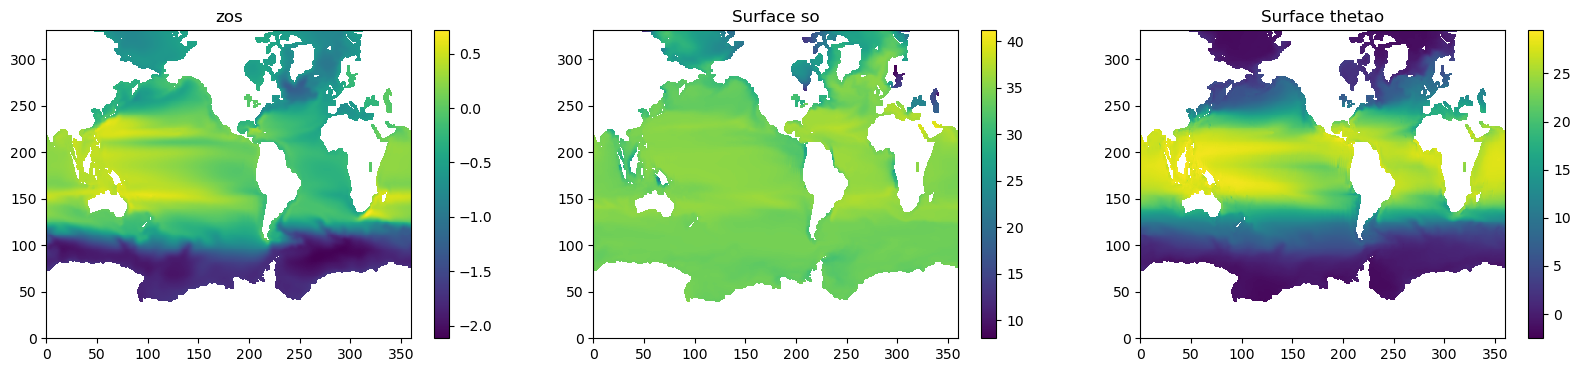

In [27]:
maps  = [predictions_zos,predictions_so,predictions_thetao]
names = ["zos","so","thetao"]

fig, axes = plt.subplots(1,len(maps), figsize=(20,4))

for i, simu in enumerate(maps):
    if len(np.shape(simu)) > 3 : 
        im = axes[i].pcolor(simu[0,0])
        axes[i].set_title(f"Surface {names[i]}")
    else:
        im = axes[i].pcolor(simu[0])
        axes[i].set_title(f"{names[i]}")
    plt.colorbar(im, ax=axes[i])


# **SAVE PREDICTIONS**

In [31]:
np.save("/data/mtissot/spinup_data/simus_predicted/pred_zos.npy", predictions_zos)
np.save("/data/mtissot/spinup_data/simus_predicted/pred_so.npy", predictions_so)
np.save("/data/mtissot/spinup_data/simus_predicted/pred_thetao.npy", predictions_thetao)

# **EVALUATE ERROR**

In [1]:
import sys
sys.path.insert(0,"../lib/")
import forecast
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from forecast import Predictions, Simulation, load_ts
#import importlib
#importlib.reload(p1)

In [2]:
pred_zos    = np.load("/data/mtissot/spinup_data/simus_predicted/pred_zos.npy")
pred_so     = np.load("/data/mtissot/spinup_data/simus_predicted/pred_so.npy")
pred_thetao = np.load("/data/mtissot/spinup_data/simus_predicted/pred_thetao.npy")

In [3]:
id_,start2,end2 ="106",25,125+30#start,end+steps
ye = False

path ="/scratchu/mtissot/SIMUp6Y"
ref_zos = Simulation(path=path,start=start2,end=end2,ye=ye,term="zos")    
print("zos loaded")
ref_so = Simulation(path=path,start=start2,end=end2,ye=ye,term="so")   
print("so loaded")
ref_thetao = Simulation(path=path,start=start2,end=end2,ye=ye,term="thetao")   
print("thetao loaded")

#REMTTRE BIEN GET DATA APRES      return grid[:1] => return grid
ref_zos.prepare(stand=False) 
print("\nzos prepared")
ref_so.prepare(stand=False) 
print("so prepared")
ref_thetao.prepare(stand=False) 
print("thetao prepared")

zos loaded
so loaded
thetao loaded

zos prepared
so prepared
thetao prepared


In [4]:
array = xr.open_dataset(ref_so.files[-1], decode_times=False,chunks={"time": 200, "x":120})
depth = array.deptht
del array

#### ERREUR PREDICTIONS

In [13]:
err_so = np.abs((ref_so.simulation - pred_so))
err_thetao = np.abs((ref_thetao.simulation - pred_thetao))
err_zos = np.abs((ref_zos.simulation - pred_zos))

i=15
mean_pred_so = np.nanmean(pred_so[-i:],axis=(0,2,3))
mean_ref_so  = np.nanmean(ref_so.simulation[-i:],axis=(0,2,3))
mean_err_so  = np.nanmean(err_so[-i:],axis=(0,2,3))
std_err_so   = np.nanstd(err_so[-i:],axis=(0,2,3))

mean_pred_thetao = np.nanmean(pred_thetao[-i:],axis=(0,2,3))
mean_ref_thetao  = np.nanmean(ref_thetao.simulation[-i:],axis=(0,2,3))
mean_err_thetao  = np.nanmean(err_thetao[-i:],axis=(0,2,3))
std_err_thetao   = np.nanstd(err_thetao[-i:],axis=(0,2,3))

mean_pred_zos = np.nanmean(pred_zos[-i:],axis=(0,1,2))
mean_pred_zos = np.nanmean(ref_zos.simulation[-i:],axis=(0,1,2))
mean_err_zos  = np.nanmean(err_zos[-i:],axis=(0,1,2))
std_err_zos   = np.nanstd(err_zos[-i:],axis=(0,1,2))

In [14]:
print(mean_err_zos+std_err_zos)
print(mean_err_zos)
print(mean_err_zos-std_err_zos)

0.04943271
0.0262738
0.0031148903


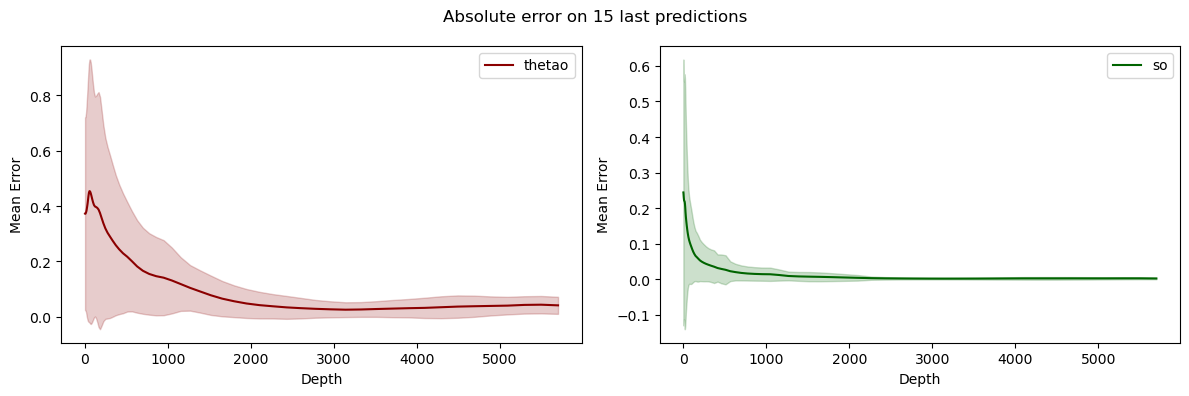

In [15]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

axes[0].plot(depth, mean_err_thetao, color="darkred", label="thetao")
axes[0].fill_between(depth, mean_err_thetao + std_err_thetao, mean_err_thetao - std_err_thetao, color="darkred", alpha=0.2)
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('Mean Error')
axes[0].legend()

axes[1].plot(depth, mean_err_so, color="darkgreen", label="so")
axes[1].fill_between(depth, mean_err_so + std_err_so, mean_err_so - std_err_so, color="darkgreen", alpha=0.2)
axes[1].set_xlabel('Depth')
axes[1].set_ylabel('Mean Error')
axes[1].legend()

fig.suptitle(f"Absolute error on {i} last predictions")
plt.tight_layout()
plt.show()

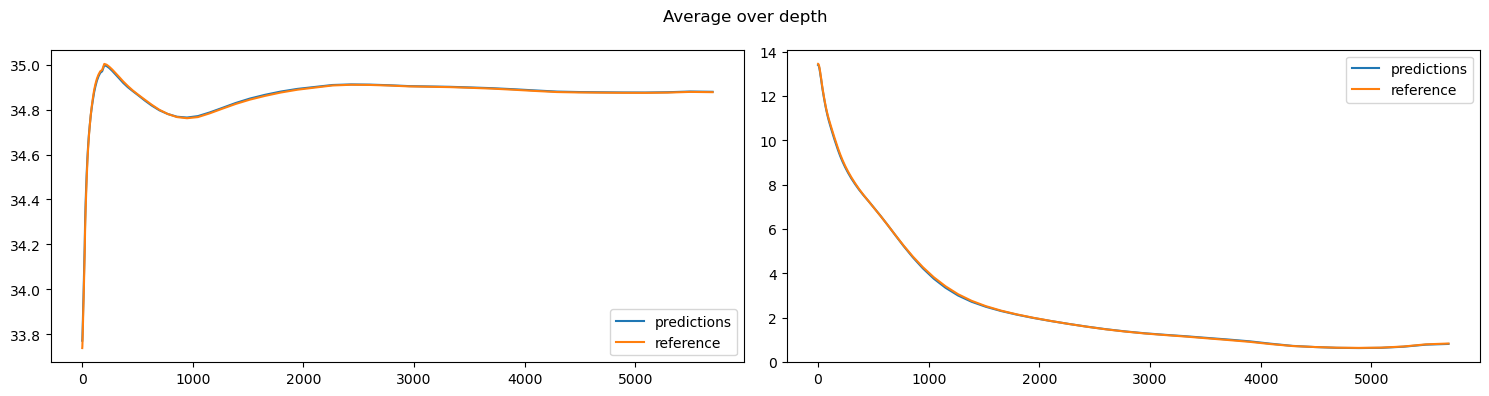

In [16]:
fig, axes = plt.subplots(1,2, figsize=(15,4))

axes[0].plot(depth,mean_pred_so,label="predictions")
axes[0].plot(depth,mean_ref_so,label="reference")
axes[0].legend()

axes[1].plot(depth,mean_pred_thetao,label="predictions")
axes[1].plot(depth,mean_ref_thetao,label="reference")
axes[1].legend()

fig.suptitle(f"Average over depth")
plt.tight_layout()
plt.show()

#### ERREUR SUR TRAIN

In [17]:
err_so = np.abs((ref_so.simulation - pred_so))
err_thetao = np.abs((ref_thetao.simulation - pred_thetao))
err_zos = np.abs((ref_zos.simulation - pred_zos))

i=30
mean_pred_so   = np.nanmean(pred_so[:-i],axis=(0,2,3))
mean_ref_so    = np.nanmean(ref_so.simulation[:-i],axis=(0,2,3))
mean_err_so    = np.nanmean(err_so[:-i],axis=(0,2,3))
std_err_thetao = np.nanstd(err_so[:-i],axis=(0,2,3))

mean_pred_thetao = np.nanmean(pred_thetao[:-i],axis=(0,2,3))
mean_ref_thetao  = np.nanmean(ref_thetao.simulation[:-i],axis=(0,2,3))
mean_err_thetao  = np.nanmean(err_thetao[:-i],axis=(0,2,3))
std_err_so       = np.nanstd(err_thetao[:-i],axis=(0,2,3))

mean_pred_zos = np.nanmean(pred_zos[:-i],axis=(0,1,2))
mean_pred_zos = np.nanmean(ref_zos.simulation[:-i],axis=(0,1,2))
mean_err_zos  =  np.nanmean(err_zos[:-i],axis=(0,1,2))
std_err_zos   =  np.nanstd(err_zos[:-i],axis=(0,1,2))

In [18]:
print(mean_err_zos+std_err_zos)
print(mean_err_zos)
print(mean_err_zos-std_err_zos)

0.028398227
0.015187423
0.0019766176


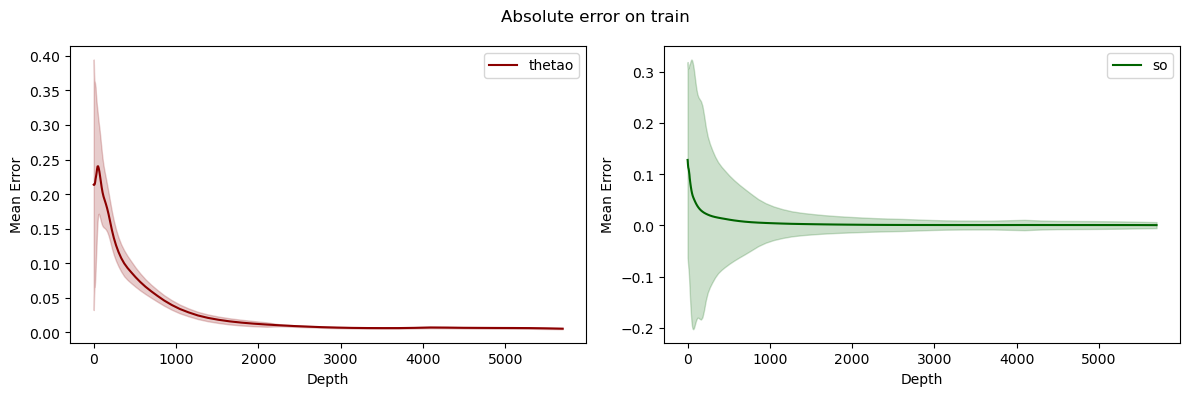

In [19]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

axes[0].plot(depth, mean_err_thetao, color="darkred", label="thetao")
axes[0].fill_between(depth, mean_err_thetao + std_err_thetao, mean_err_thetao - std_err_thetao, color="darkred", alpha=0.2)
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('Mean Error')
axes[0].legend()

axes[1].plot(depth, mean_err_so, color="darkgreen", label="so")
axes[1].fill_between(depth, mean_err_so + std_err_so, mean_err_so - std_err_so, color="darkgreen", alpha=0.2)
axes[1].set_xlabel('Depth')
axes[1].set_ylabel('Mean Error')
axes[1].legend()

fig.suptitle("Absolute error on train")
plt.tight_layout()
plt.show()

### PROPAGATION ERREUR TEMPS

In [20]:
err_so = np.abs((ref_so.simulation - pred_so))
err_thetao = np.abs((ref_thetao.simulation - pred_thetao))
err_zos = np.abs((ref_zos.simulation - pred_zos))

mean_pred_so = np.nanmean(pred_so,axis=(2,3))
mean_ref_so  = np.nanmean(ref_so.simulation,axis=(2,3))
mean_err_so  = np.nanmean(err_so,axis=(2,3))
std_err_thetao   = np.nanstd(err_so,axis=(2,3))

mean_pred_thetao = np.nanmean(pred_thetao,axis=(2,3))
mean_ref_thetao  = np.nanmean(ref_thetao.simulation,axis=(2,3))
mean_err_thetao  = np.nanmean(err_thetao,axis=(2,3))
std_err_so       = np.nanstd(err_thetao,axis=(2,3))

mean_pred_zos = np.nanmean(pred_zos,axis=(1,2))
mean_ref_zos = np.nanmean(ref_zos.simulation,axis=(1,2))
mean_err_zos  =  np.nanmean(err_zos,axis=(1,2))
std_err_zos   =  np.nanstd(err_zos,axis=(1,2))

In [22]:
np.shape(mean_err_so)

(130, 75)

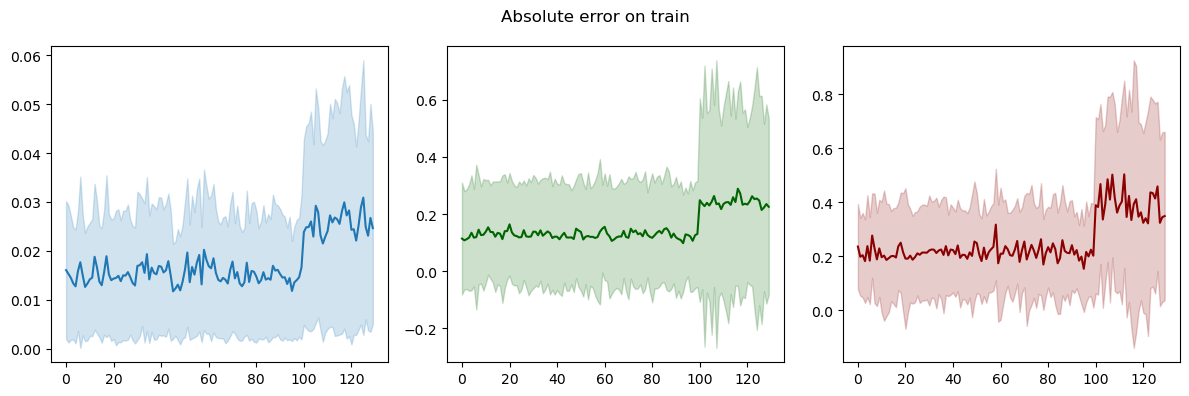

In [33]:
mean_err  = [mean_err_zos,mean_err_so, mean_err_thetao]
std_err   = [std_err_zos,std_err_so, std_err_thetao]
colors = ["tab:blue", "darkgreen", "darkred"]

fig, axes = plt.subplots(1,3, figsize=(12,4))

axes[0].plot(mean_err[0], color=colors[0], label="zos")
axes[0].fill_between(np.arange(mean_err[0].shape[0]), mean_err[0] - std_err[0], mean_err[0] + std_err[0], color=colors[0], alpha=0.2)

for i in range(1,3):
    axes[i].plot(mean_err[i][:, 0], color=colors[i], label="thetao")
    axes[i].fill_between(
        np.arange(mean_err[i].shape[0]), 
        mean_err[i][:, 0] - std_err[i][:, 0], 
        mean_err[i][:, 0] + std_err[i][:, 0], 
        color=colors[i], 
        alpha=0.2
    )

#axes[0].set_xlabel('Depth')
#axes[0].set_ylabel('Mean Error')
#axes[0].legend()

fig.suptitle("Absolute error on train")
plt.tight_layout()
plt.show()

### Evaluate time series and predictions

In [53]:
ref_zos.simulation    = (ref_zos.simulation    - ref_zos.desc["mean"])   /(2*ref_zos.desc["std"])
ref_so.simulation     = (ref_so.simulation     - ref_so.desc["mean"])    /(2*ref_so.desc["std"])
ref_thetao.simulation = (ref_thetao.simulation - ref_thetao.desc["mean"])/(2*ref_thetao.desc["std"])

ref_zos.applyPCA()
print("PCA applied on zos")
ref_so.applyPCA()
print("PCA applied on so")
ref_thetao.applyPCA()
print("PCA applied on thetao")

PCA applied on zos
PCA applied on so
PCA applied on thetao


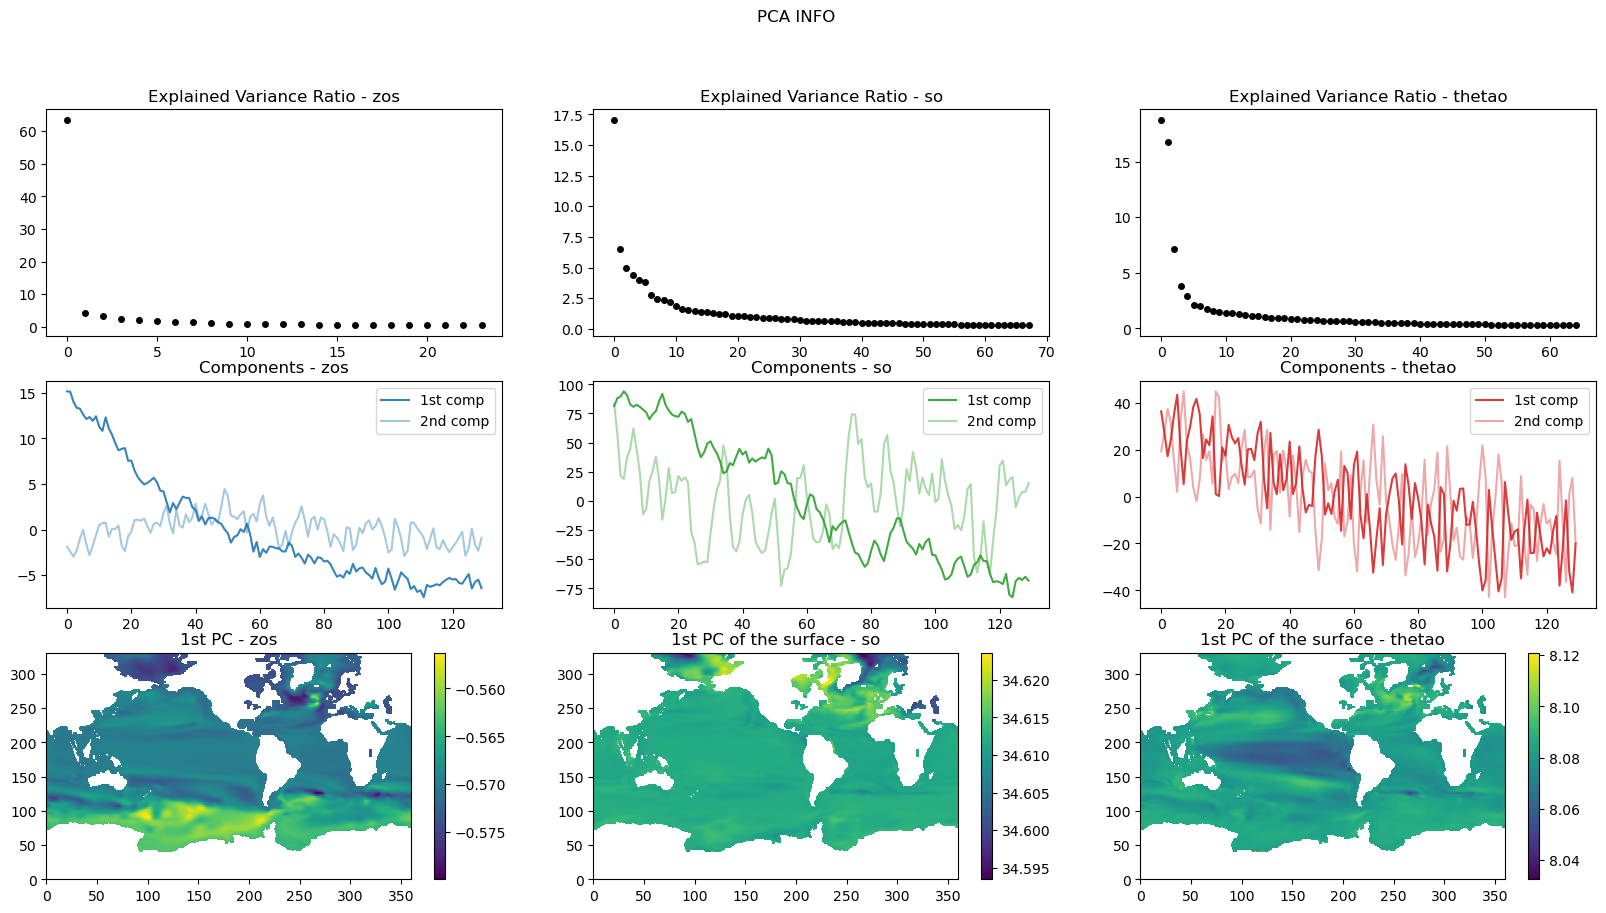

In [54]:
simus  = [ref_zos,ref_so,ref_thetao]
names  = ["zos","so","thetao"]
colors = ["tab:blue","tab:green","tab:red"]
fig, axes = plt.subplots(3, 3, figsize=(20, 10))

for i, simu in enumerate(simus):
    axes[0, i].plot(simu.pca.explained_variance_ratio_*100,"ko", markersize =4)
    axes[0, i].set_title(f"Explained Variance Ratio - {names[i]}")

    axes[1, i].plot(simu.components[:, 0], color=colors[i], alpha=0.9, label="1st comp")
    axes[1, i].plot(simu.components[:, 1], color=colors[i], alpha=0.4, label="2nd comp")
    axes[1, i].set_title(f"Components - {names[i]}")
    axes[1, i].legend()
    
    if simu.z_size is not None : 
        im = axes[2, i].pcolor(simu.getPC(0)[0])
        plt.colorbar(im, ax=axes[2, i])#,label=units[i])
        axes[2, i].set_title(f"1st PC of the surface - {names[i]}")
    else:
        im = axes[2, i].pcolor(simu.getPC(0))
        plt.colorbar(im, ax=axes[2, i])#,label=units[i])
        axes[2, i].set_title(f"1st PC - {names[i]}")
        
fig.suptitle("PCA INFO")
plt.show()

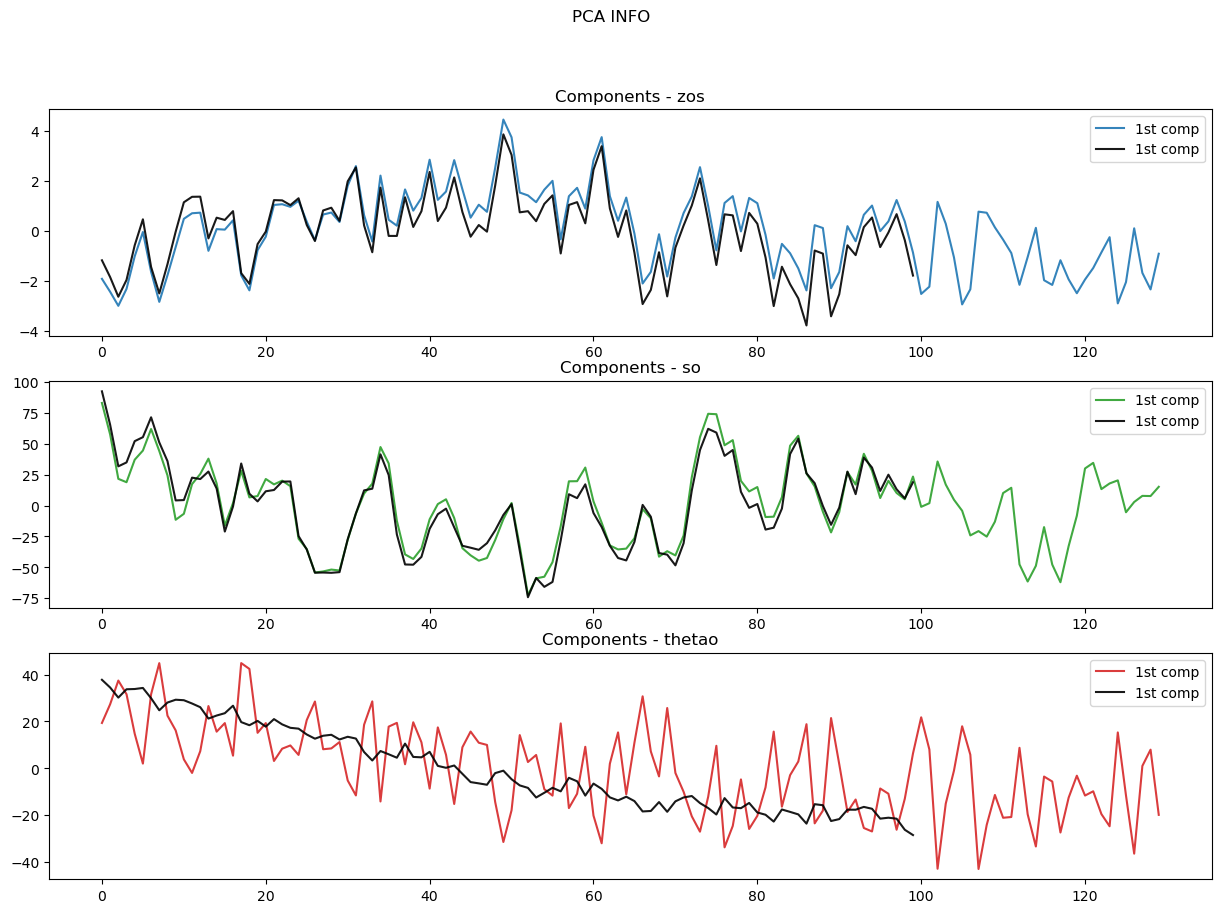

In [61]:
comp   = 1
ref    = [ref_zos,ref_so,ref_thetao]
df     = [df_zos,df_so,df_thetao]
names  = ["zos","so","thetao"]
colors = ["tab:blue","tab:green","tab:red"]

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for i, simu in enumerate(ref):
    axes[i].plot(simu.components[:, comp], color=colors[i], alpha=0.9, label="1st comp")
    axes[i].plot(df[i].iloc[:,comp], color="black", alpha=0.9, label="1st comp")
    axes[i].set_title(f"Components - {names[i]}")
    axes[i].legend()
    
fig.suptitle("PCA INFO")
plt.show()